*Sentiment Analysis of 2016 election data*

# Library imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""to remove emojis and urls, special characters"""
import preprocessor as p
import re, unicodedata 

"""NLTK"""
import nltk
from nltk import word_tokenize  
from nltk.corpus import stopwords 

"""to Normalize the text"""
import contractions  
import inflect 

In [3]:
"""sentiment score"""
import textblob
from afinn import Afinn

"""Word clouds"""
from collections import Counter
from wordcloud import WordCloud


# Load data - data pre-processing

## Load the candidate tweets data

In [4]:
clinton = pd.read_csv("./HillaryClinton.csv")
trump = pd.read_csv("./realDonaldTrump.csv")
clinton.shape, trump.shape

((7457, 13), (9361, 13))

### replace Null values with a space

In [5]:
clinton['text'] = clinton.text.fillna(' ')
trump['text'] = trump.text.fillna(' ')

### clean all text
* 1. to remove emojis and urls 
* 2. convert to lowercase text
* 3. remove numbers
* 4. remove punctuation
* 5. remove whitespaces


#### Function to Replace numbers to text

In [6]:
"""Replace all digits to text"""
def inflectReplaceNbrs(text_list):
    p2 = inflect.engine()
    words = []
    for word in text_list:
        if word.isdigit():
            new_word = p2.number_to_words(word)
            words.append(new_word)
        else:
            words.append(word)
    return words



#### Function to Remove stop words

In [7]:
"""Remove stop words"""
def remove_stopwords(text_list):
    words = []
    for word in text_list:
        if word not in stopwords.words('english'):
            words.append(word)
    return words

#### Function to normalize the tweets

In [8]:
def normalizeText(text):
    text = p.clean(text) ## clean the text - removes emojis and urls
    text = re.sub('\[[^]]*\]', '', text)  ## removes all special characters
    text = contractions.fix(text)  ## to replace contracted words
    ## removes non-Ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = text.lower() ## converts to lowercase
    text = re.sub(r'[^\w\s]', '', text)  ## removes punctuation
    text_list = nltk.word_tokenize(text) ## tokenize the string
    
    text_list = inflectReplaceNbrs(text_list)
    text_list = remove_stopwords(text_list)
    #text_list  = ' '.join(normalizeText(text_list))
    return text_list

### pre-processing data for Clinton tweets

In [9]:
for i, row in clinton.iterrows():    
    clinton.at[i, 'text'] = ' '.join(normalizeText(row.text))

### pre-processing data for Trump tweets

In [10]:
for i, row in trump.iterrows():
    trump.at[i, 'text'] = ' '.join(normalizeText(row.text))

# Assign Sentiment Scores - using Afinn and textblob

## Assigning a sentiment using textblob - polarity

In [11]:
clinton['sentimentPolarity'] = clinton['text'].apply(lambda x: textblob.TextBlob(x).sentiment[0])
trump['sentimentPolarity'] = trump['text'].apply(lambda x: textblob.TextBlob(x).sentiment[0])

## Assigning a sentiment using Afinn

In [12]:
af = Afinn()

clinton['afinnScore'] = clinton['text'].apply(lambda x: af.score(x))
trump['afinnScore'] = trump['text'].apply(lambda x: af.score(x))

## Assign textual values as well

In [13]:
trump['score_text'] = ' '
trump['score_text'] = trump['afinnScore'].apply(lambda x: 'Positive' if x > 0 else 'Neutral' if x == 0 else 'Negative')
clinton['score_text'] = ' '
clinton['score_text'] = clinton['afinnScore'].apply(lambda x: 'Positive' if x > 0 else 'Neutral' if x == 0 else 'Negative')


# Check the min and max dates - assign day, month and year as different columns

## Check min and max dates in both trump and clinton dataframes

In [14]:
pd.to_datetime(trump.date).min(), pd.to_datetime(trump.date).max()

(Timestamp('2015-01-04 00:00:00'), Timestamp('2017-12-01 00:00:00'))

In [15]:
pd.to_datetime(clinton.date).min(), pd.to_datetime(clinton.date).max()

(Timestamp('2015-01-04 00:00:00'), Timestamp('2017-03-01 00:00:00'))

 ## Assign a month, date and year fields out of the date

In [16]:
clinton['day'], clinton['month'], clinton['year'] = pd.to_datetime(clinton.date).dt.day, pd.to_datetime(clinton.date).dt.month, pd.to_datetime(clinton.date).dt.year
trump['day'], trump['month'], trump['year'] = pd.to_datetime(trump.date).dt.day, pd.to_datetime(trump.date).dt.month, pd.to_datetime(trump.date).dt.year

# clinton['monthYear'] = pd.to_datetime(clinton['date']).apply(lambda x: x.strftime('%B-%Y'))
# trump['monthYear'] = pd.to_datetime(trump['date']).apply(lambda x: x.strftime('%B-%Y'))


## Get relevant fields from trump and clinton dataframes

In [17]:
clinton_df = clinton[['tweet_id', 'favorites', 'replies', 'retweets', 'sentimentPolarity', 'afinnScore', 'score_text', 'day', 'month', 'year']]
trump_df = trump[['tweet_id', 'favorites', 'replies', 'retweets', 'sentimentPolarity', 'afinnScore', 'score_text', 'day', 'month', 'year']]
clinton_df.shape, trump_df.shape

((7457, 10), (9361, 10))

# Load poll data

In [18]:
pollData = pd.read_csv("./presidential_polls.csv")
pollData.shape

(10236, 7)

## Check the min and max dates in poll data & assign day, month and year as different columns

### check the minimum and maximum of start dates

In [19]:
pd.to_datetime(pollData.startdate).min(), pd.to_datetime(pollData.startdate).max()

(Timestamp('2015-11-06 00:00:00'), Timestamp('2016-10-30 00:00:00'))

### Assign day, month and year fields out of start date

In [20]:
date = pd.to_datetime(pollData.startdate)
pollData['startDay'], pollData['startMonth'], pollData['startYear'] = date.dt.day, date.dt.month, date.dt.year
del date


### check the minimum and maximum of end dates

In [21]:
pd.to_datetime(pollData.enddate).min(), pd.to_datetime(pollData.enddate).max()

(Timestamp('2015-11-08 00:00:00'), Timestamp('2016-10-31 00:00:00'))

### Assign day, month and year fields out of end date

In [22]:
date = pd.to_datetime(pollData.enddate)
pollData['endDay'], pollData['endMonth'], pollData['endYear'] = date.dt.day, date.dt.month, date.dt.year
del date


## get relevant data from pollData

In [23]:
poll_df = pollData[['poll_id', 'state', 'adjpoll_clinton', 'adjpoll_trump', 'startDay', 'startMonth', 'startYear', 'endDay', 'endMonth', 'endYear']]
poll_df.shape


(10236, 10)

### Considering overall U.S poll details

In [24]:
poll_df_US = poll_df[poll_df.state == 'U.S.']
poll_df_US.shape

(3105, 10)

### Get mean poll date for month and year combination

In [25]:

mean_polls = poll_df_US[['adjpoll_clinton', 'adjpoll_trump', 'startDay', 'startMonth', 'startYear', 'endDay', 'endMonth', 'endYear']].groupby(['startMonth', 'startYear', 'endMonth', 'endYear'])\
                .agg({'adjpoll_clinton': np.mean, 'adjpoll_trump': np.mean})\
                .reset_index()
mean_polls = mean_polls.groupby(['startMonth', 'startYear'])\
                .agg({'adjpoll_clinton': np.mean, 'adjpoll_trump': np.mean})\
                .reset_index()

mean_polls.shape


(12, 4)

**Since we have poll data from November 2015 - October 2016, we are considering candidate tweets in the same period**

### Get tweets from Nov'2015 - Oct'16

In [26]:
clinton_df = clinton_df[((clinton_df.year == 2015) & (clinton_df.month > 10)) | ((clinton_df.year == 2016) & (clinton_df.month < 11))]
trump_df = trump_df[((trump_df.year == 2015) & (trump_df.month > 10)) | ((trump_df.year == 2016) & (trump_df.month < 11))]
clinton_df.shape, trump_df.shape


((5335, 10), (4575, 10))

### Also Assign a column "order_months" to maintain month year order.

In [27]:
clinton_df['order_months'] = ' '
trump_df['order_months'] = ' '

for i, row in clinton_df.iterrows():  
    if row.month in [11, 12] and row.year == 2015:
        
        clinton_df.loc[i, 'order_months'] = str(str(row.month) + "'15")
    else:
        clinton_df.loc[i, 'order_months'] = str(str(row.month) + "'16")
        
for i, row in trump_df.iterrows():  
    if row.month in [11, 12] and row.year == 2015:
        trump_df.loc[i, 'order_months'] = str(str(row.month) + "'15")
    else:
        trump_df.loc[i, 'order_months'] = str(str(row.month) + "'16")

# merge the poll results with clinton and trump data frames

In [28]:
clinton_df['polls_favor'] = np.NaN
clinton_df['polls_notfavor'] = np.NaN
trump_df['polls_favor'] = np.NaN
trump_df['polls_notfavor'] = np.NaN
mean_polls['adjpoll_clinton'] = mean_polls['adjpoll_clinton'].fillna(0)
mean_polls['adjpoll_trump'] = mean_polls['adjpoll_trump'].fillna(0)

## assign values

In [29]:
for i, row in clinton_df.iterrows(): 
    clinton_df.at[i, 'polls_favor'] = mean_polls[(mean_polls.startMonth == row.month) & (mean_polls.startYear == row.year)]['adjpoll_clinton'].values[0]
    clinton_df.at[i, 'polls_notfavor'] = 100 - clinton_df.at[i, 'polls_favor']

for i, row in trump_df.iterrows():    
    trump_df.at[i, 'polls_favor'] = mean_polls[(mean_polls.startMonth == row.month) & (mean_polls.startYear == row.year)]['adjpoll_trump'].values[0]
    trump_df.at[i, 'polls_notfavor'] = 100 - trump_df.at[i, 'polls_favor']
    

# Word clouds

In [30]:
"""word Counter"""
def wordCounter(dfCol):
    d = Counter()
    dfCol.apply(lambda t: d.update(t.split()))    
    return pd.DataFrame.from_dict(d, orient='index').rename(columns={0: 'count'})\
                                    .sort_values('count', ascending=False)

In [31]:
"""word cloud"""
def wordCloud(dictionary):
    return WordCloud(background_color='black', max_words=200, max_font_size=100, random_state=456)\
                        .generate_from_frequencies(dictionary.to_dict()['count'])

## Word clouds for both clinton and trump tweets

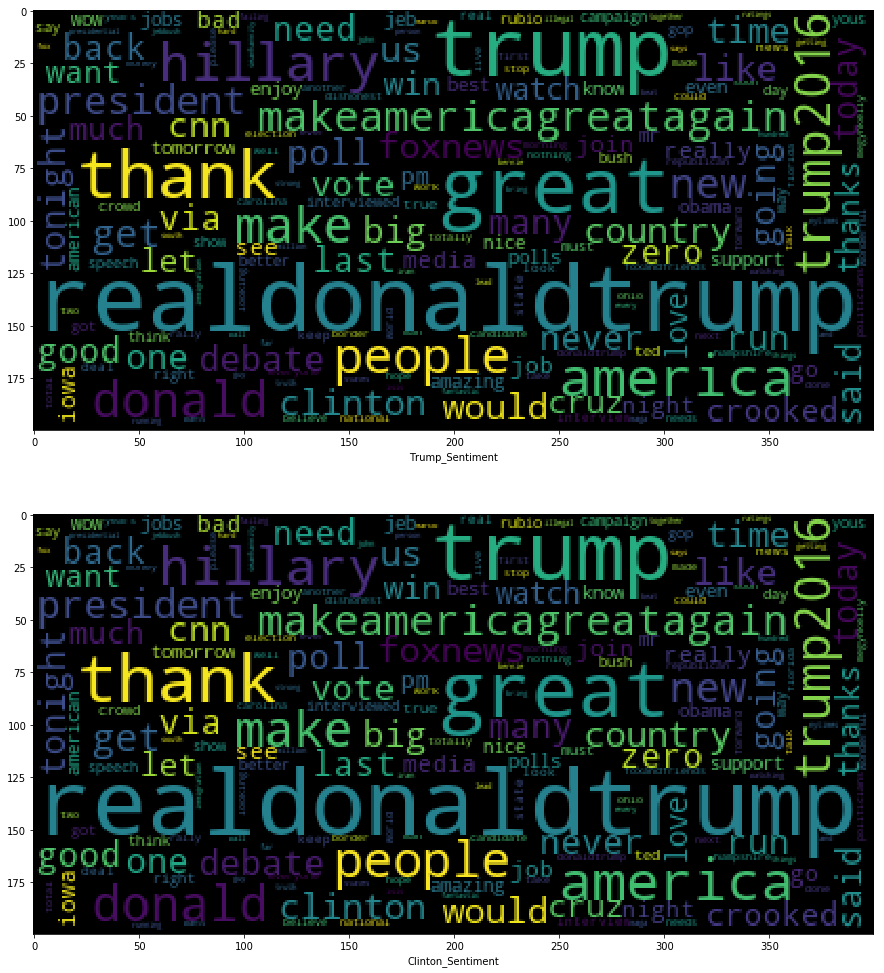

In [32]:
"""Define word counter dictionaries for both the candidates"""
word_counter1 = {}
word_counter2 = {}
categ = "sentiment"

word_counter1[categ] = wordCounter(trump['text'])    
word_counter2[categ] = wordCounter(clinton['text'])

"""create wordClouds for both the candidates"""
wc1 = word_counter1[categ]
wc2 = word_counter2[categ]
wordcloud1 = wordCloud(wc1)
wordcloud2 = wordCloud(wc2)

"""Plot the wordClouds for both the candidates"""
labels = ['Trump_Sentiment', 'Clinton_Sentiment']

plt.figure(figsize=(20, 17))
for i in range(2): 
    plt.subplot(2, 1, i + 1)
    plt.imshow(wordcloud1)
    plt.xlabel(labels[i])
plt.show();

**We see that the word "trump" or "realDonaldTrump" has been used extensively by both the candidates and it looks like more a person is talked about or publicised matters in the election outcome**

# Plots - relation between attributes: favorites, replies, retweets, sentiment score, sentiment counts with month and year

## Plots on Trump Tweets

### monthly favorites vs yearly favorites

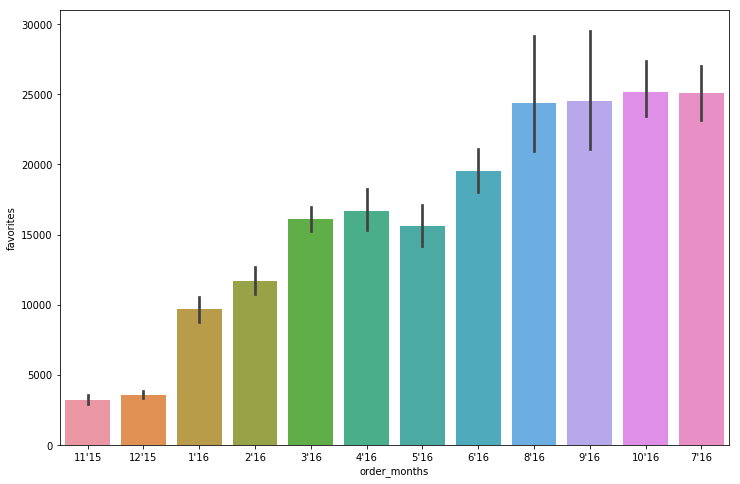

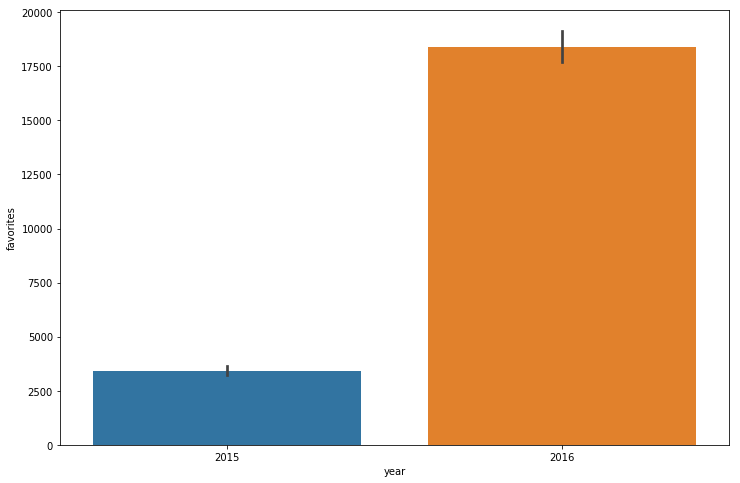

In [33]:
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='order_months', y='favorites', data=trump_df);
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='year', y='favorites', data=trump_df);

**We can clearly see that the number of people who have favorited Trump's tweets have increased steadily, with the exception of May'16.
We also see that the number of people who have favorited Trump's tweets have increased by 500% in 2016**

### monthly favorites vs yearly replies

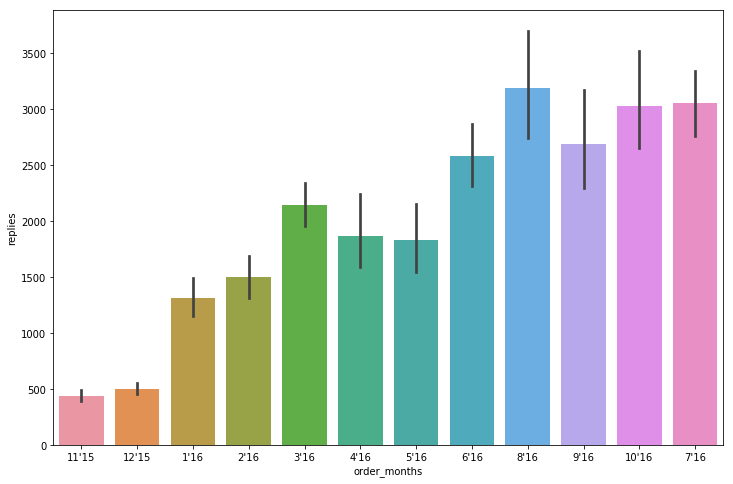

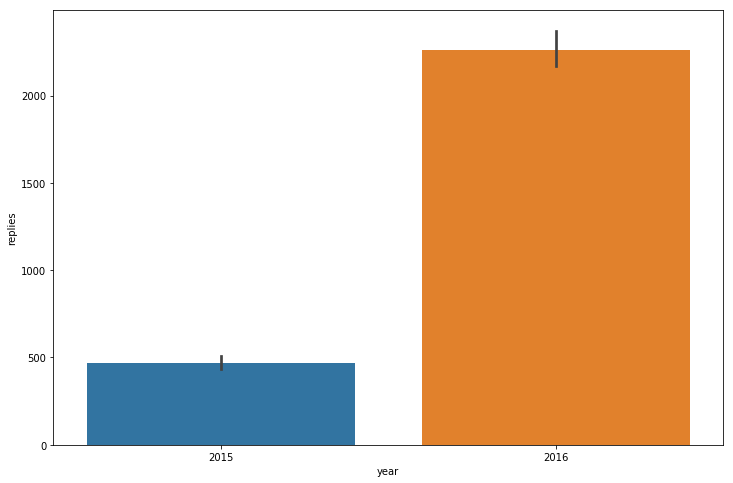

In [34]:
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='order_months', y='replies', data=trump_df);
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='year', y='replies', data=trump_df);


**We can clearly see that the number of replies to Trump's tweets have increased drastically in the start of Jan'2016 and kept on increasing with a clear exception of Sep'16, the period when the results were announced. We also see that the number of replies to Trump's tweets have increased by 400% in 2016**

### monthly favorites vs yearly retweets

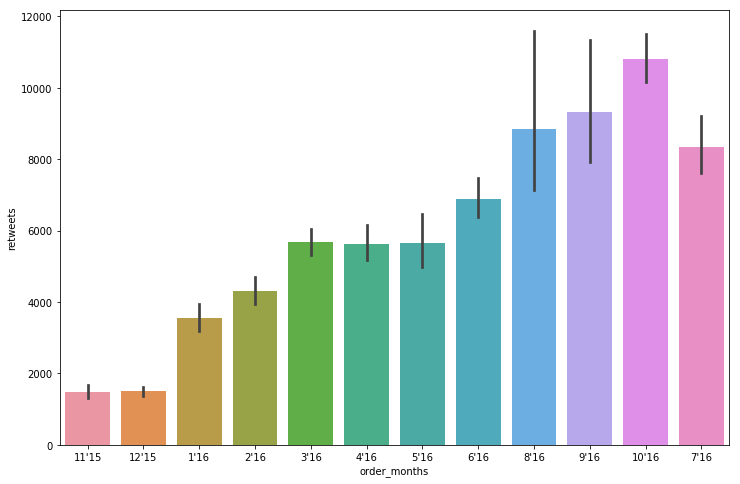

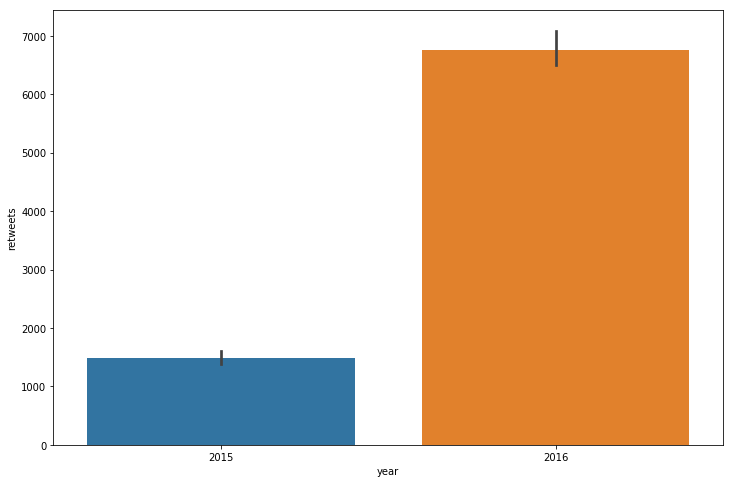

In [35]:
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='order_months', y='retweets', data=trump_df);
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='year', y='retweets', data=trump_df);

**We can clearly see that the number of retweets of Trump's tweets have increased gradually from the start of Jan'2016. We also see that the number of retweets of Trump's tweets have increased by 400% in 2016**

### monthly favorites vs yearly sentiment score

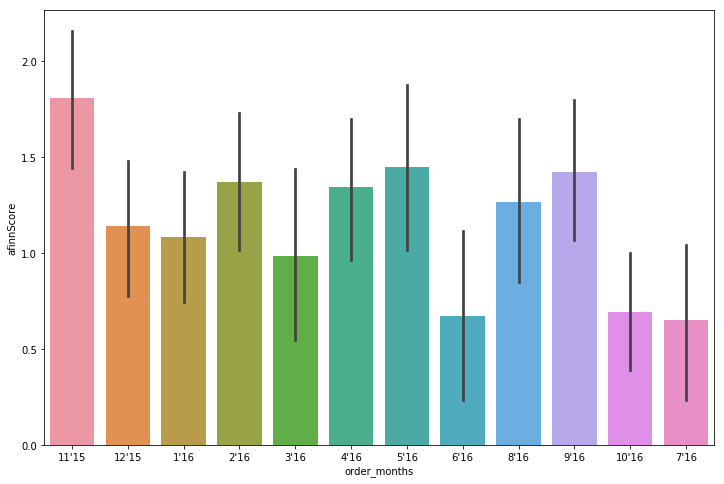

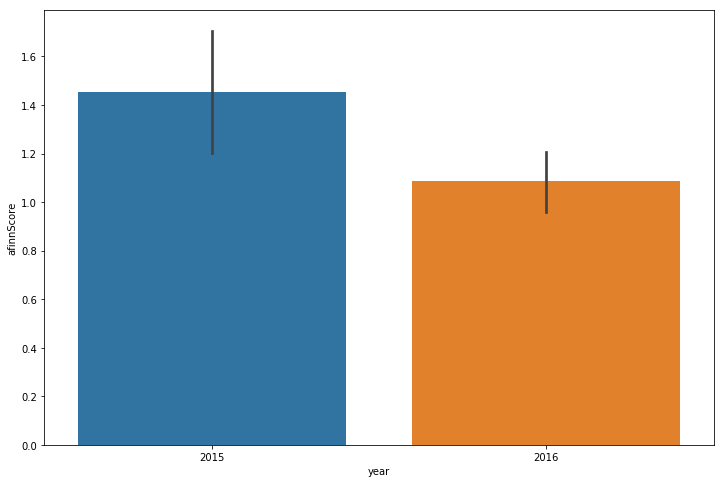

In [36]:
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='order_months', y='afinnScore', data=trump_df);
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='year', y='afinnScore', data=trump_df);

**We can clearly see that the Afinn score of Trump's tweets have fluctuated through out the election period. We also see that the Afinn score of Trump's tweets were much higher in 2015 than in 2016**

### Sentiment counts

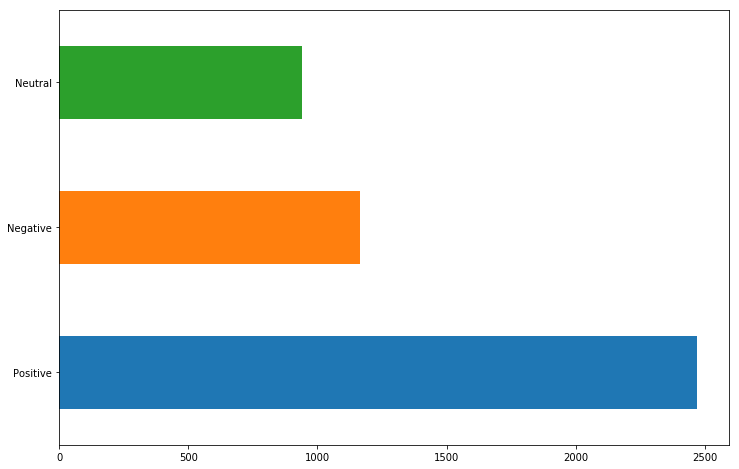

In [37]:
plt.figure(figsize=(12, 8))
trump_df.score_text.value_counts().plot(kind = 'barh')

**We see that Trump made a lot of positive polarity tweets when compared to negative and neutral**

## Plots on clinton tweets

### monthly favorites vs yearly favorites

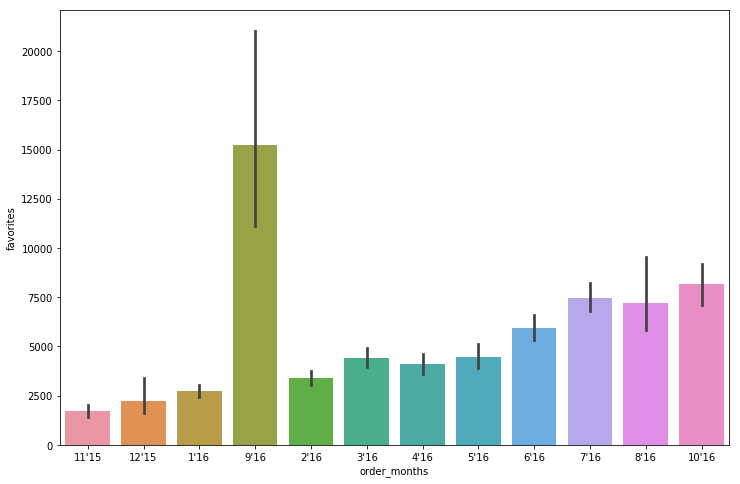

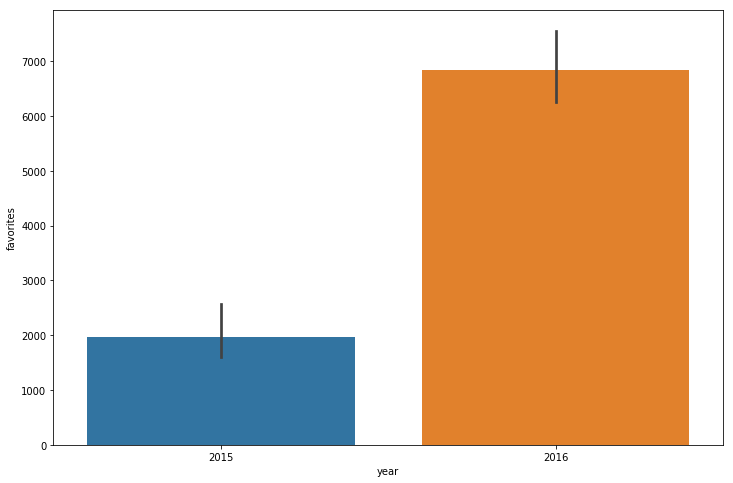

In [38]:
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='order_months', y='favorites', data=clinton_df);
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='year', y='favorites', data=clinton_df);

**We can clearly see that the number of people who have favorited Clinton's tweets have increased steadily, with a drastic change in the month of election results announcement (Sep'16), followed by a decrease. We also see that the number of people who have favorited Clinton's tweets have increased by 200% in 2016**

### monthly favorites vs yearly replies

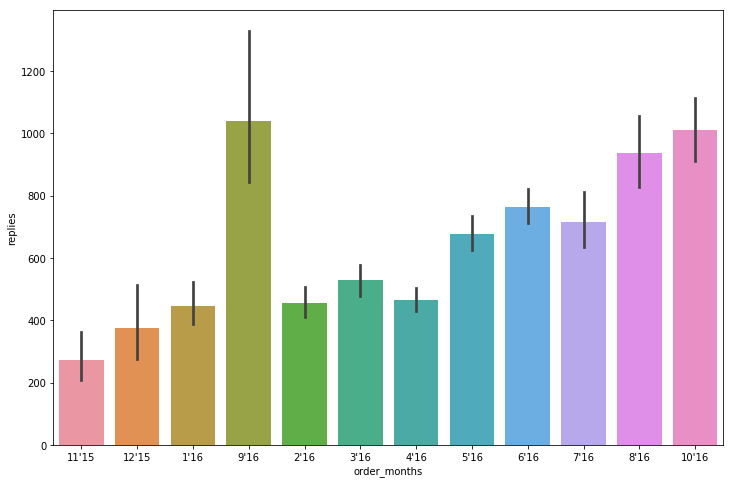

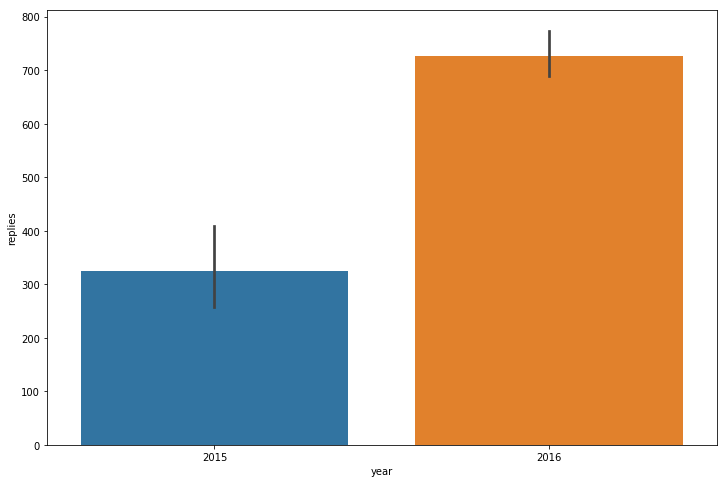

In [39]:
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='order_months', y='replies', data=clinton_df);
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='year', y='replies', data=clinton_df);

**We can clearly see that the number of replies to Clinton's tweets have fluctuated in the election period, increased for a brief period in Sep'16 and Oct'16 when people thought Clinton would win the election and then dropped completely. We also see that the number of replies to Clinton's tweets have increased by 120% in 2016**

### monthly favorites vs yearly retweets

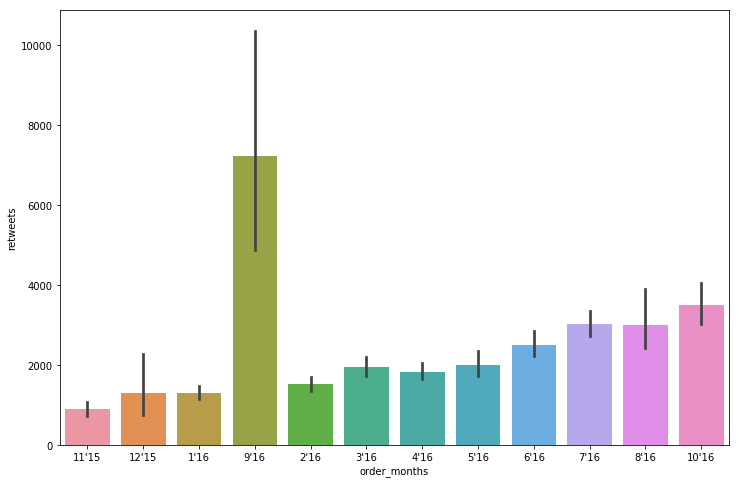

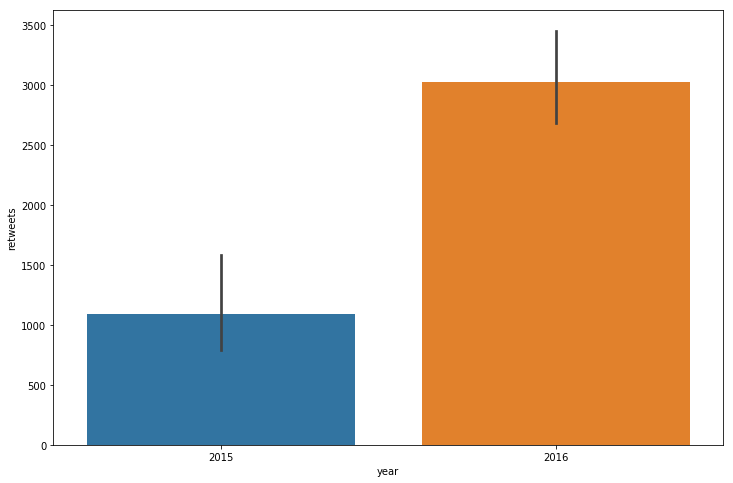

In [40]:
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='order_months', y='retweets', data=clinton_df);
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='year', y='retweets', data=clinton_df);

**We can clearly see that the number of retweets of Clinton's tweets have increased gradually with a sudden spike in Sep'16 when the results were announced and reduced subsequently. We also see that the number of retweets of Clinton's tweets have increased by 150% in 2016**

### monthly favorites vs yearly sentiment score

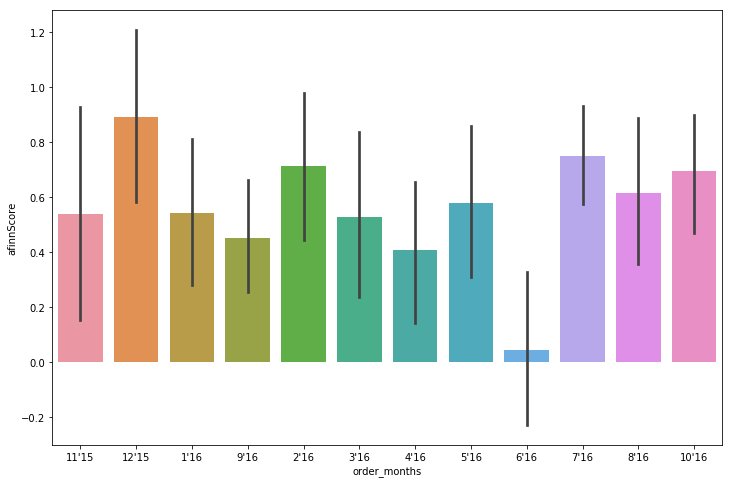

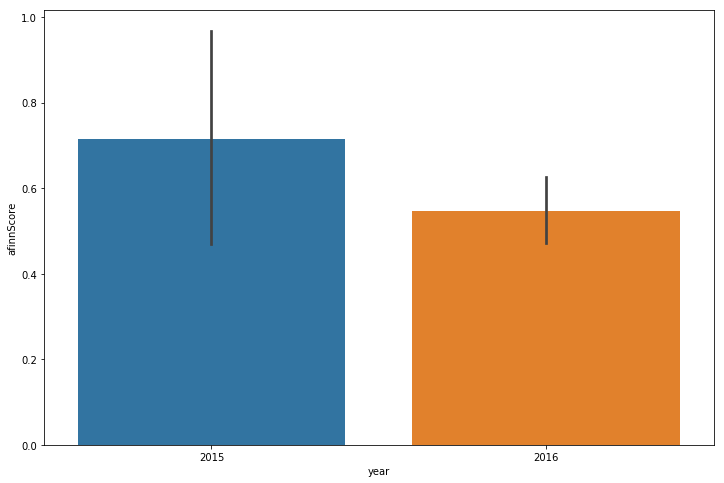

In [41]:
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='order_months', y='afinnScore', data=clinton_df);
fig, ax=plt.subplots(figsize=(12, 8))
sns.barplot(x='year', y='afinnScore', data=clinton_df);

**We can clearly see that the Afinn score of Clinton's tweets have fluctuated through out the election period. We also see that the Afinn score of Clinton's tweets was conisderably the same but much lesser when compared to Trump's score in 2015 than in 2016**

### Sentiment Counts

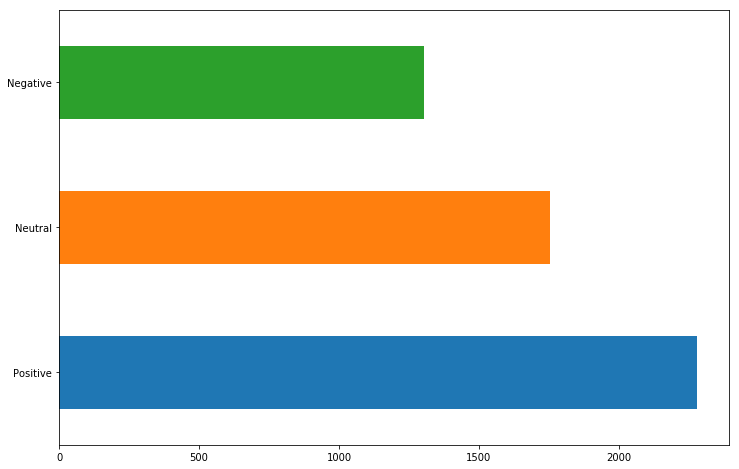

In [42]:
plt.figure(figsize=(12, 8))
clinton_df.score_text.value_counts().plot(kind = 'barh')

**We see from above plot which clearly shows us that Clinton made a lot of negative polarity tweets**

## Model Fitting - Prediction positive poll percentage

In [43]:
trump_df["polls_favor"] = trump_df["polls_favor"].fillna(0)
trump_df[["afinnScore"]] = trump_df[["afinnScore"]].fillna(0)
trump_df[["sentimentPolarity"]] = trump_df[["sentimentPolarity"]].fillna(0)

clinton_df["polls_favor"] = clinton_df["polls_favor"].fillna(0)
clinton_df[["afinnScore"]] = clinton_df[["afinnScore"]].fillna(0)
clinton_df[["sentimentPolarity"]] = clinton_df[["sentimentPolarity"]].fillna(0)

trump_df['afinnScore'].shape, trump_df['polls_favor'].shape, clinton_df['afinnScore'].shape, clinton_df['polls_favor'].shape


((4575,), (4575,), (5335,), (5335,))

### Fit a linear regression model

In [44]:
from sklearn import linear_model
X = np.array(trump_df[['sentimentPolarity']])[:4000]
y = np.array(trump_df["polls_favor"])[:4000]
regr = linear_model.LinearRegression()

regr.fit(X, y)
print(regr.coef_)

[0.18333515]


### obtain predictions

In [45]:
test = np.array(trump_df[['sentimentPolarity']])[4000:]
true = np.array(trump_df[['polls_favor']])[4000:]
pred = regr.predict(test)

### Accuracy

In [46]:
regr.score(test, pred[0:]) 

1.0

**Here we have got an accuracy score of 1, however we need more data before we conclude that our model makes accurate predictions**

### predictions and test values plot

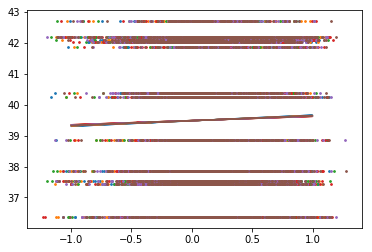

In [47]:
plt.figure() 
np.random.seed(0)
for _ in range(6): 
    this_X = .1 * np.random.normal(size=(4000, 1)) + X
    regr.fit(this_X, y)
    plt.plot(test, regr.predict(test))
    plt.scatter(this_X, y, s=3) 

## Conclusion and Results

**When comparing all the plots for the five variables - number of people who favorited a tweet, number of retweets, number of likes, Afinn sentiment score, and number of tweets of different polarity for both Trump's tweets and Clinton's tweets, we can conclude the below.**


**1. we find that the sentiment score remained almost the same for Clinton and there was some slow increase in the counts of three variables in consideration**

**2. Sentiment score for Trump was very high compared to Clinton, leading us to believe there was a lot of positive tweets made by him in 2015 when compared to 2016. Also, there was a significant increase in the counts of the three variables in consideration**

**3. Also, the Trump made a lot of positive tweets when compared to neutral and negative tweets in stark comparision to Clinton, who made a lot of negative tweets when compared to neutral and positive tweets**

**4. The word clouds we have plotted show that both the candidates spoke mostly about Trump, increasing his popularity and outreach. It might have been a reason contributing to his win** 

**5. We would need to consider more tweets data for both the candidates and poll data for different months, to be able to accurately predict the polls using sentiment score for the tweets**